In [1]:
# Adding the path of the agent's class as a system path
import sys
sys.path.append('../src')
import EV_Agent as ev_agent_py
import Line_Agent as line_agent_py

# Importing required libraries
import subprocess
import argparse
import math
import pandas as pd
from tqdm import tqdm
import pandapower as pp
from pandapower.plotting.plotly import pf_res_plotly
from pandapower.plotting.plotly import simple_plotly
from pandapower.plotting import simple_plot
import time
import numpy as np
import matplotlib.pyplot as plt
import pandapower.networks as nw
from pandapower.plotting import simple_plot, simple_plotly
from scipy import signal
from itertools import chain
from statistics import mean
import math
import random
from functools import reduce
from scipy import signal, spatial
from scipy.stats import norm
import time
from tqdm import tqdm
import  seaborn as sns

## IEEE LVTF Network
### Constructing IEEE network using PandaPower

In [2]:
# Path to the folder with network data
args = {'csv_path': r'../data/network/European_LV_CSV_simplified/'}

In [3]:
args.update({'nb_sub_districts': 1})  #Number of Sub-Districts (Default 1)
args.update({'unbalanced': False}) #Unbalanced or Balanced Network (Default False)
args.update({'draw': False}) #Draw network or not
args.update({'nb_districts': 1}) #Number of Districts (Default 1)
args.update({'output': "network.json"}) #Output format of the network

In [4]:
#Initializations of coordinates to draw(plot) the network
h_step = 200
v_step_2 = 200
v_step = v_step_2 * args['nb_sub_districts']

# geodata limits from ELVTF
x_min = 390868.753
y_min = 392747.256

# Import ELVTF dataframes
buses = pd.read_csv(args['csv_path'] + "Buscoords.csv", header=1)
lines = pd.read_csv(args['csv_path'] +"Lines.csv", header=1)
loads = pd.read_csv(args['csv_path'] + "Loads.csv", header=2)

In [5]:
# There battery storage in PandaPower does not include SoC and SoH variables etc. Defining a method to modify the PandaPower storage type to include these variables
# soc_percent = SoC value
# soh_percent = SoH value
# eff_chrg = efficiency charging
# eff_dischrg = efficiency discharging
# n_cycles = total number of cycles of the battery
# dod = depth of discharge
def create_storage_pp(net, name, bus, p_mw=0.0, max_e_mwh=0.03, soc_percent=0.5, soh_percent=0.5, eff_chrg = 0.96, eff_dischrg = 0.95,
                     n_cycles=14000, dod=0.4):
    pp.create_storage(net, bus, p_mw = p_mw, max_e_mwh = max_e_mwh, soc_percent = soc_percent, name = name);
    net.storage['soh_percent'] = soh_percent;
    net.storage['eff_chrg'] = eff_chrg;
    net.storage['eff_dischrg'] = eff_dischrg;
    net.storage['n_cycles'] = n_cycles;
    net.storage['dod'] = dod;

In [6]:
# Defining loads in the network based on the network type.
# If the network is unbalanced, loads are attached based on the phase data
# If the network is balanced, loads are attached without any phase consideration
if args['unbalanced']:
	def create_load_from_row(row):
		P = 0
		S = P / 0.95
		Q = math.sqrt(S**2 - P**2)
		bus = pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus"]) + "_" + str(i) + "_" + str(j))
		if row["phases"] == "A":
			pp.create_asymmetric_load(net, bus=bus, p_a_mw=P, q_a_mvar=Q, name=row["Name"])
		elif row["phases"] == "B":
			pp.create_asymmetric_load(net, bus=bus, p_b_mw=P, q_b_mvar=Q, name=row["Name"])
		elif row["phases"] == "C":
			pp.create_asymmetric_load(net, bus=bus, p_c_mw=P, q_c_mvar=Q, name=row["Name"])
		else:
			print("ERROR: unkown phase")
else:
	def create_load_from_row(row):
		P = 2 * 1e-3
		S = P / 0.95
		Q = math.sqrt(S**2- P**2)
        # Creating loads
		pp.create_load(net, bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus"]) + "_" + str(i) + "_" + str(j)),
			p_mw=P, q_mvar=Q, name=row["Name"])
        # Creating PV generators at the load buses
		#pp.create_sgen(net, bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus"]) + "_" + str(i) + "_" + str(j)),
		#	p_mw=0.00, q_mvar=0, name=row["Name"])
        # Creating EV battery storage at the load buses
		create_storage_pp(net, name="EV" + row["Name"][4:], bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus"]) + "_" + str(i) + "_" + str(j)),
			p_mw=0.0, max_e_mwh=30.0,soc_percent=0.3, soh_percent=0.9, eff_chrg = 0.96, eff_dischrg = 0.95, n_cycles=14000, dod=0.4 )

In [7]:
# Defining a method to create a line type from the input data
def create_line_type_from_row(row):
	dic = {
	"r_ohm_per_km": row["R1"],
	"x_ohm_per_km": row["X1"],
	"r0_ohm_per_km": row["R0"],
	"x0_ohm_per_km": row["X0"],
	"c_nf_per_km": row["C1"],
	"c0_nf_per_km": row["C0"],
	"max_i_ka": 1 # arbitrary value
	}
	pp.create_std_type(net, dic, row["Name"], element="line")

In [8]:
# Creating an empty network
net = pp.create_empty_network()
# Lines types
# from ELVTF
pd.read_csv(args['csv_path'] + "LineCodes.csv", header=1).apply(create_line_type_from_row, axis=1);

In [9]:
# Creating the required transformer type

dic = {
    "sn_mva": 0.8,
    "vn_hv_kv": 11,
    "vn_lv_kv": 0.416,
    "vk_percent": 4.01995,
    "vkr_percent": 0.4,
    "pfe_kw": 0,
    "i0_percent": 0,
    "shift_degree": 180,
    "vk0_percent": 6,
    "vkr0_percent": 1.30,
    "vector_group": 'Yyn',
    "mag0_percent": 100,
    "mag0_rx": 0,
    "si0_hv_partial": 0.9
}
pp.create_std_type(net, dic, "ELVTF", element="trafo")

In [10]:
# Populating the electrical network

i=1
j=1


# Ext Grid
pp.create_bus(net, vn_kv=11, name="bus_ext", geodata=(0,0))
pp.create_ext_grid(net, bus = pp.get_element_index(net,"bus", "bus_ext"), vm_pu = 1.01,
                   name = 'ext_grid', s_sc_max_mva=2286, rx_max=0.09, x0x_max=1, r0x0_max=0.09)
pp.create_sgen(net, bus=pp.get_element_index(net,"bus", "bus_ext"), p_mw=0.00, q_mvar=0, name='pv_ext')
# Buses ELVTF
buses.apply(lambda row:
    pp.create_bus(net, 0.416, 
        name="bus_ELVTF_" + str(int(row["Busname"])) + "_" + str(i) + "_" + str(j),
        geodata=(7 * h_step + row[" x"] - x_min, v_step * i + v_step_2 * j + row[" y"] - y_min)), axis=1)
#Transformers T2
pp.create_transformer(net, 
    hv_bus = pp.get_element_index(net, "bus","bus_ext"),
    lv_bus=pp.get_element_index(net, "bus","bus_ELVTF_1_"  + str(i) + "_" + str(j)),
    std_type='ELVTF',name="trafo")
# Lines ELVTF
lines.apply(lambda row:
    pp.create_line(net, 
        from_bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus1"]) + "_" + str(i) + "_" + str(j)),
        to_bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus2"]) + "_" + str(i) + "_" + str(j)),
        length_km=row["Length"]/1000.0, std_type=row["LineCode"], name=row["Name"]), axis=1)
# Loads ELVTF
loads.apply(create_load_from_row, axis=1);

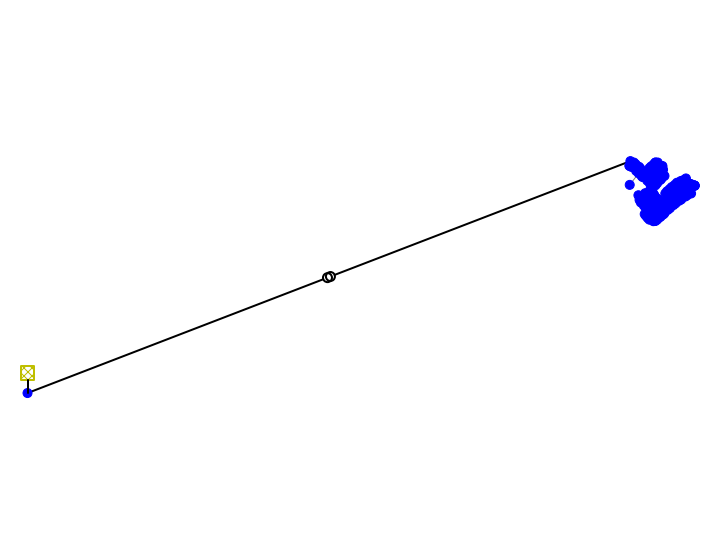

In [11]:
# Making a simple plot of the network
simple_plot(net, scale_size=True, ext_grid_size=1.0, trafo_size=1.0, bus_size=1.0);

In [12]:
# Customized run power flow method to incorporate customized battery storage method earlier
def runpp_pp(net, time_step = 1):
    # Running power flow
    pp.runpp(net);
    net.res_storage['soc_percent'] = 0.0000001;
    net.res_storage['soh_percent'] = 0.0000001;
    # Update SoC and SoH of each storage
    for i in range(0,len(net.storage)):
        soc_f = net.storage['soc_percent'][i] + ((((net.storage['p_mw'][i])*(time_step/3600)*net.storage['eff_chrg'][i])/net.storage['max_e_mwh'][i]) if (net.storage['p_mw'][i]>0) else (((net.storage['p_mw'][i])*(time_step/3600))/(net.storage['max_e_mwh'][i]*net.storage['eff_dischrg'][i])))
        soh_f = net.storage['soh_percent'][i] + (0 if (net.storage['p_mw'][i]>0) else (((net.storage['p_mw'][i])*(time_step/3600))/(0.2*net.storage['max_e_mwh'][i]*net.storage['eff_dischrg'][i]*net.storage['n_cycles'][i]*net.storage['dod'][i])))
        soc_f = min(max(0,soc_f),1)
        soh_f = min(max(0,soh_f),1)
        net.res_storage['soc_percent'].at[i] = soc_f;
        net.res_storage['soh_percent'].at[i] = soh_f;

# Assigning SoC and SoH results of this time step as the input of the next time step
def update_states(net):
    for i in range(0,len(net.storage)):
        net.storage['soc_percent'].at[i] = net.res_storage['soc_percent'][i]
        net.storage['soh_percent'].at[i] = net.res_storage['soh_percent'][i]

# Simulation Data

### Simulation Variables

In [13]:
days = 30  #Total number of simulation days
p_max = 7  #Max charging power of EV agent (in kW)
e_bat = 54  #Battery capacity of EV agent (in kWh)
bat_eff = 0.95 #Charging efficiency of the battery
daily_decision_instants  = 1440 #Number of decision instants in a day
congestion_limit = 56 #in kW

In [14]:
#Normalized electricity price
electricity_price = np.loadtxt(r'../data/electricity price/electricity price.csv', delimiter=",")
#Orignal electricity price (non-normalized)
electricity_price_original = np.loadtxt(r'../data/electricity price/electricity_price_original.csv', delimiter=",")

### Load Data

In [15]:
load_active_power = np.zeros([len(net.load),1440])
load_reactive_power = np.zeros([len(net.load),1440])
for i in range(0,len(net.load)):
    load_profile_df = pd.read_csv(r'../data/loads/Load Profiles/Load_profile_' + str(i+1) + '.csv' , index_col=False)
    orignal_data_load = load_profile_df['mult'].values[0:1440]
    load_active_power[i] = np.array(orignal_data_load)
    load_reactive_power[i] = load_active_power[i]* math.tan(math.acos(0.95))

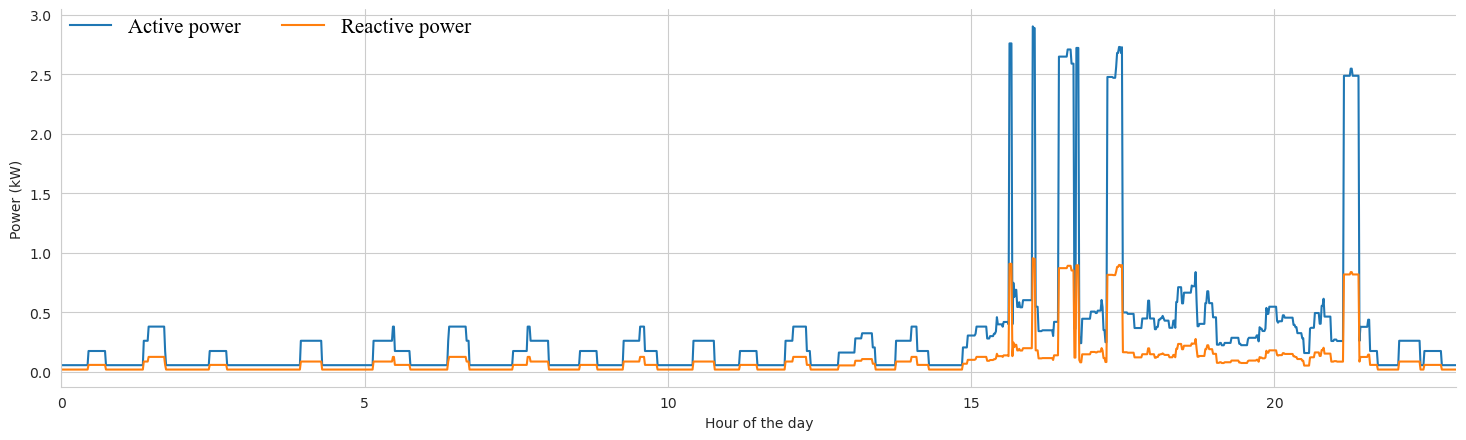

In [16]:
load_number = 54

fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)
plt.plot(np.linspace(0,23,1*1440),load_active_power[load_number])
plt.plot(np.linspace(0,23,1*1440),load_reactive_power[load_number])
plt.xlabel('Hour of the day')
plt.ylabel('Power (kW)')
plt.xlim(0,23)
plt.grid(visible=None)
plt.legend(['Active power', 'Reactive power'], fontsize=15, loc='upper left', ncol = 3, borderaxespad=0, frameon=False)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1)

### Solar Data

In [17]:
# Reading solar data

new_index = {} # Dictitonary to index dataframe
data = {}
year_last = int('2020')+1

#Starting and ending time of the data
y1 = '01/01/'+'2020'+' 00:00'
y2 = '31/12/'+'2020'+' 23:55'

new_index.update({'2020': pd.date_range(y1,y2,freq='5T')}) # Create an index for the dataset

data_file = pd.read_csv(r'../data/solar/2020.csv',low_memory=False)
data_file.columns = data_file.iloc[1] # Change the columns name

# Extract important data for application, ie GHI :Gloal horizontal Iradiance
data_bis = pd.DataFrame(data=data_file.iloc[2:,[7,10]])
data_bis.index=new_index['2020']

for elmm in data_bis.columns:
    data_bis[elmm] = np.array(data_bis[elmm], dtype=float)

data.update({'2020':data_bis })

In [18]:
# Arranging data into training and evaluation sets
solar_data = np.zeros([30,1440])
d = 0
start_index = 87840
for i in range(130,130+30):
    day_data_df = signal.resample(data['2020']['GHI'][i*288:(i+1)*288].values,1440)
    solar_data[d] = day_data_df * 0.00268784 * 100

    d = d+1
solar_data[solar_data<0] = 0
solar_mean = np.mean(solar_data, axis=0)

solar_data_eval = np.zeros([30,1440])
d = 0
start_index = 87840
for i in range(130+30,130+60):
    day_data_df = signal.resample(data['2020']['GHI'][i*288:(i+1)*288].values,1440)
    solar_data_eval[d] = day_data_df * 0.00268784 * 100

    d = d+1
solar_data_eval[solar_data_eval<0] = 0
solar_eval_mean = np.mean(solar_data_eval, axis=0)

### EVs data

In [19]:
# Reading EVs data (arrival times, departure times, initial SoC, final SoC, chrage required)
evs_df = pd.read_csv(r'../data/evs/ev_data_55.csv' , index_col=False)
evs_df.head()

,t_arrive,t_depart(d+1),soc_i,soc_f,chrg_req
0,1286,694,0.394787,0.8,191
1,650,550,0.525077,0.8,129
2,1069,411,0.629884,0.8,80
3,1330,438,0.663350,0.8,65
4,961,33,0.598379,0.8,95


# Simulations

## Uncontrolled Simulation

In [20]:
# List Variable to store results
ext_grid_p_b = [] #Active power of the external grid
ext_grid_q_b = [] #Reactive power of the external grid
line_current_b = [] #Line current in the studied congested line
voltage_b = [] #Voltage at the last bus of the network
trfo_p_b = [] #Active power through the transformer

# Executing power flows for each minute of the simulation days
for t in tqdm(range(0,1*daily_decision_instants)):
    # Minute and hour of the day
    minute_of_day = t%1440
    hour = int(math.ceil((minute_of_day+1)/60))-1

    # Setting active and reactive powers of the loads and the generators
    for l in range(0,len(net.load)):
        net.load['p_mw'][l] = load_active_power[l][minute_of_day]/1000
        net.load['q_mvar'][l] = load_reactive_power[l][minute_of_day]/1000
        net.sgen['p_mw'][l] = solar_data_eval[int(np.floor(t/1440))][minute_of_day]/1000

    # If the current instant of the day is in the uncontrolled charging policy of the EV then it charges at max power, otherwise not
    for l in range(0,len(net.storage)):
        ev_dumb_charging_slots = np.linspace(evs_df['t_arrive'][l] , evs_df['t_arrive'][l] +
                                             evs_df['chrg_req'][l], evs_df['chrg_req'][l]+1)%daily_decision_instants
        if(minute_of_day in ev_dumb_charging_slots):
            net.storage['p_mw'][l] = (p_max/1000)
        else:
            net.storage['p_mw'][l] = 0

    #Running Power Flow
    runpp_pp(net, time_step = 60)
    update_states(net)
    #Storing results after the power flow
    ext_grid_p_b.append(net.res_ext_grid['p_mw'][0])
    ext_grid_q_b.append(net.res_ext_grid['q_mvar'][0])
    line_current_b.append(net.res_line['i_ka'][0])
    voltage_b.append(net.res_bus['vm_pu'][205])
    trfo_p_b.append(net.res_trafo['p_lv_mw'][0])

100%|██████████| 1440/1440 [01:45<00:00, 13.67it/s]


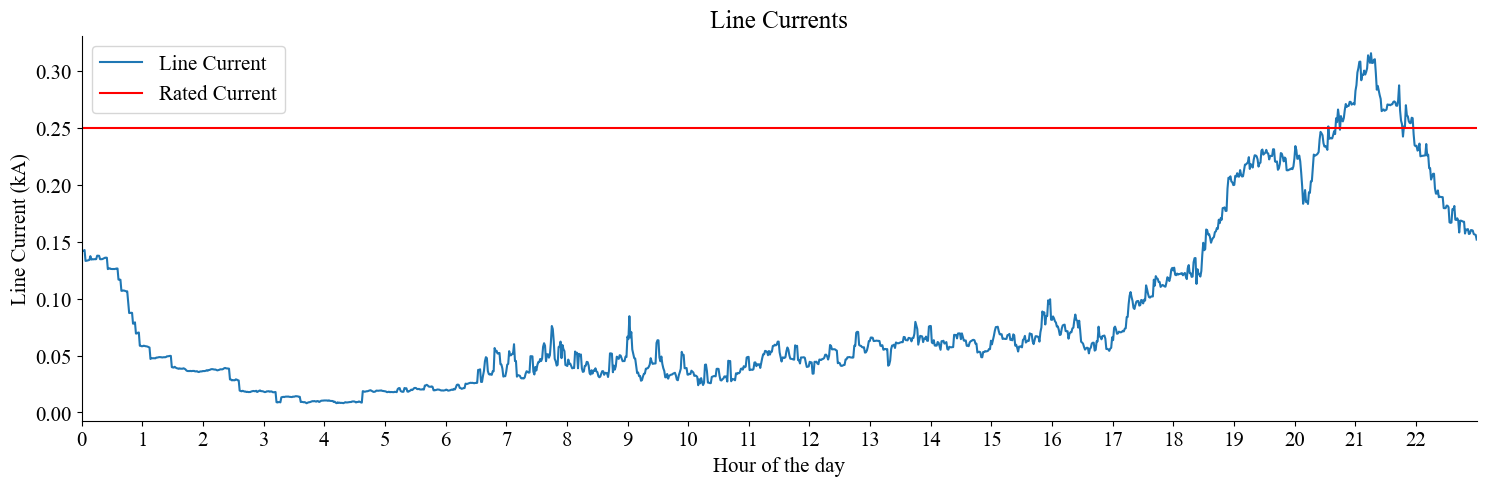

In [21]:
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)
plt.plot(np.linspace(0,23,1*1440),np.array(line_current_b))
plt.xlabel('Hour of the day')
plt.axhline(y=0.25, color='r', linestyle='-')
plt.legend(['Line Current', 'Rated Current'])
plt.ylabel('Line Current (kA)')
plt.title('Line Currents')
plt.xlim(0,23)
plt.xticks([i for i in range(0,23)]);
#plt.ylim(0,0.5)
plt.grid(visible=None)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1);

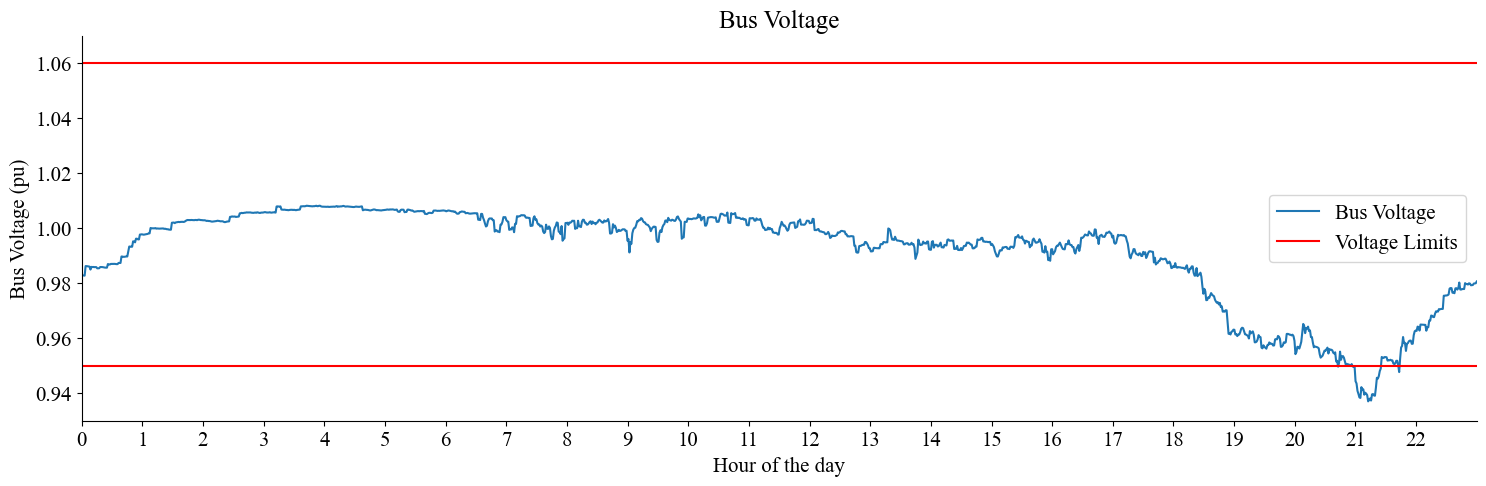

In [22]:
fig, ax = plt.subplots(figsize=(18, 5), dpi=100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family': 'Times New Roman', 'size': 15}
plt.rc('font', **font)
plt.plot(np.linspace(0,23,1*1440),np.array(voltage_b))
plt.xlabel('Hour of the day')
plt.axhline(y=1.06, color='r', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.legend(['Bus Voltage', 'Voltage Limits'])
plt.ylabel('Bus Voltage (pu)')
plt.title('Bus Voltage')
plt.xlim(0,23)
plt.xticks([i for i in range(0,23)]);
plt.ylim(0.93,1.07)
plt.grid(visible=None)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1);

## Combinatorial Bandits (without PV)

In [23]:
# Plot of EVs charging simultaneously at each instant
ev_slots = np.linspace(evs_df['t_arrive'][0] , 1440+evs_df['t_depart(d+1)'][0], (1440-evs_df['t_arrive'][0]) + evs_df['t_depart(d+1)'][0]+1)%1440
evs_p = np.zeros(1440)
for t in tqdm(range(0,1440)):
    for e in range(0,len(net.storage)):
        ev_slots = np.linspace(evs_df['t_arrive'][e] , 1440+evs_df['t_depart(d+1)'][e], (1440-evs_df['t_arrive'][e]) + evs_df['t_depart(d+1)'][e]+1)%1440
        if(t in ev_slots):
            evs_p[t] = evs_p[t] + 1

100%|██████████| 1440/1440 [00:06<00:00, 222.88it/s]


In [24]:
# Declaring EV agents for each EV in the network
ev_agents_index  = np.ndarray((len(net.storage)),dtype=object)
for e in range(0,len(net.storage)):
    ev_agents_index[e] = ev_agent_py.EV_Agent(net.storage['name'][e],evs_df['t_arrive'][e],evs_df['t_depart(d+1)'][e],
                                  evs_df['chrg_req'][e],1,electricity_price,100,0* solar_data[29]/24)

In [25]:
# Declaring line agent for the studied congested electrical line
line_agent = line_agent_py.Line_Agent('Line 0', 0.27, electricity_price)

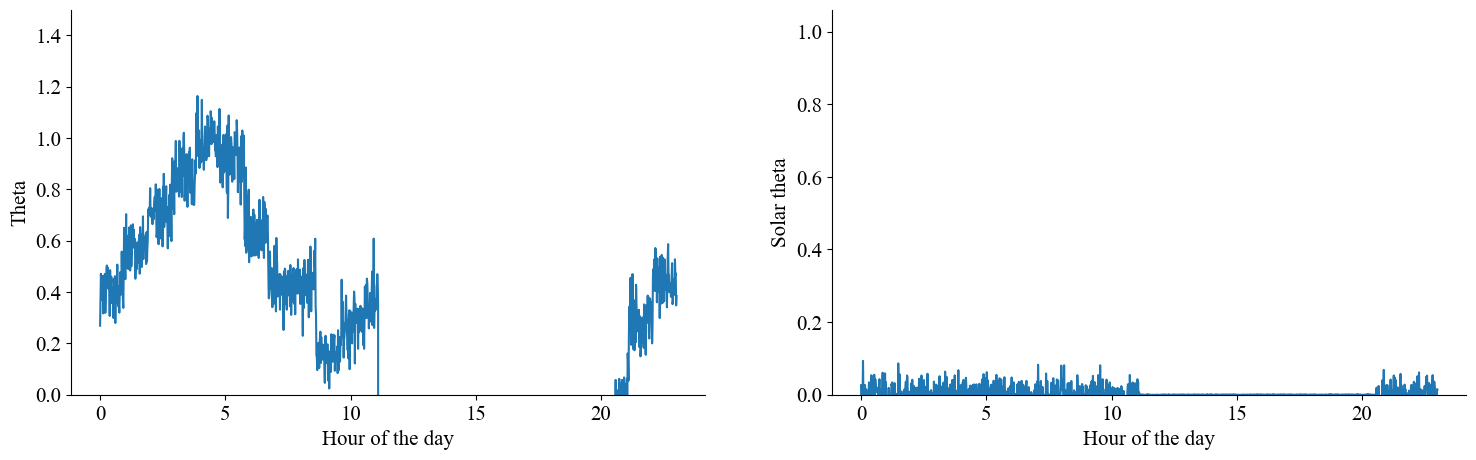

In [26]:
fig, ax = plt.subplots(figsize=(18, 5), dpi=100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family': 'Times New Roman', 'size': 15}
plt.rc('font', **font)

plt.subplot(1,2,1)
plt.grid(visible=None)
plt.plot(np.linspace(0,23,1440),ev_agents_index[0].theta)
plt.grid(visible=None)
plt.xlabel('Hour of the day')
plt.ylabel('Theta')
plt.ylim(0,1.5)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1);

plt.subplot(1,2,2)
plt.grid(visible=None)
plt.plot(np.linspace(0,23,1440),ev_agents_index[0].theta_solar)
plt.xlabel('Hour of the day')
plt.ylabel('Solar theta')
plt.ylim(0,1.06)
plt.grid(visible=None)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1);

In [27]:
# Variables to store simulation results
ext_grid_p_npv = []
ext_grid_q_npv = []
line_current_npv = []
avg_rewards_npv = np.zeros((len(net.storage),days*daily_decision_instants))
reward_hist_npv = np.zeros((len(net.storage),days*daily_decision_instants))
voltage_npv = []
trfo_p_npv = []


# Executing power flow simulation for each instant of the simulation days
for t in tqdm(range(0,days*daily_decision_instants)):
    minute_of_day = t%1440
    hour = int(math.ceil((minute_of_day+1)/60))-1

    #Select a charging policy at the begining of the day
    if (minute_of_day == 0):
        for a in range(0,len(ev_agents_index)):
            ev_agents_index[a].select_actions()

    #Set active and reactive powers of the loads and the generators
    for l in range(0,len(net.load)):
        net.load['p_mw'][l] = load_active_power[l][minute_of_day]/1000
        net.load['q_mvar'][l] = load_reactive_power[l][minute_of_day]/1000
        net.sgen['p_mw'][l] = solar_data[int(np.floor(t/daily_decision_instants))][minute_of_day]/1000

    #Setting charging power of each EV agent based on its charging policy
    for l in range(0,len(net.storage)):
        if(minute_of_day in ev_agents_index[l].selected_actions):
            net.storage['p_mw'][l] = (p_max/1000)
        elif (minute_of_day in np.where(ev_agents_index[l].solar_estimate>=0.2)[0]):
            net.storage['p_mw'][l] = (ev_agents_index[l].solar_estimate[minute_of_day]/1000)
        else:
            net.storage['p_mw'][l] = 0

    #Running Power Flow
    runpp_pp(net, time_step = 60)
    update_states(net)
    ext_grid_p_npv.append(net.res_ext_grid['p_mw'][0])
    ext_grid_q_npv.append(net.res_ext_grid['q_mvar'][0])
    line_current_npv.append(net.res_line['i_ka'][0])
    for l in range(0,len(net.storage)):
        ev_agents_index[l].inst_voltage = net.res_bus['vm_pu'][net.storage['bus'][l]]

    #Line agent rewarding each charging EV agent
    line_agent.reward_evs(minute_of_day, net.res_line['i_ka'][0], ev_agents_index)
    #Storing results
    voltage_npv.append(net.res_bus['vm_pu'][205])
    trfo_p_npv.append(net.res_trafo['p_lv_mw'][0])
    #Calculating average rewards
    for e in range(0,len(net.storage)):
        avg_rewards_npv[e][t] = avg_rewards_npv[e][t-1] + (ev_agents_index[e].get_avg_reward() - avg_rewards_npv[e][t-1])/(t+1)
        reward_hist_npv[e][t] = (ev_agents_index[e].get_avg_reward())

100%|██████████| 43200/43200 [50:07<00:00, 14.37it/s]


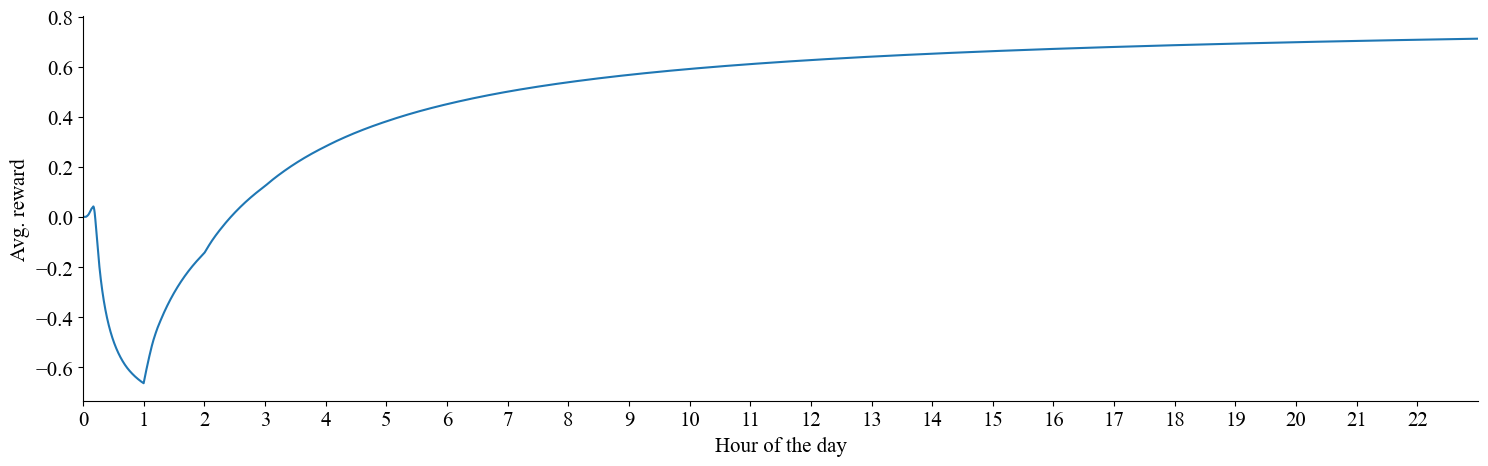

In [28]:
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)
plt.plot(np.linspace(0,days,days*1440), np.mean(np.array(avg_rewards_npv), axis = 0))
plt.xlabel('Hour of the day')
plt.ylabel('Avg. reward')
plt.xlim(0,23)
plt.xticks([i for i in range(0,23)]);
plt.grid(visible=None)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1);

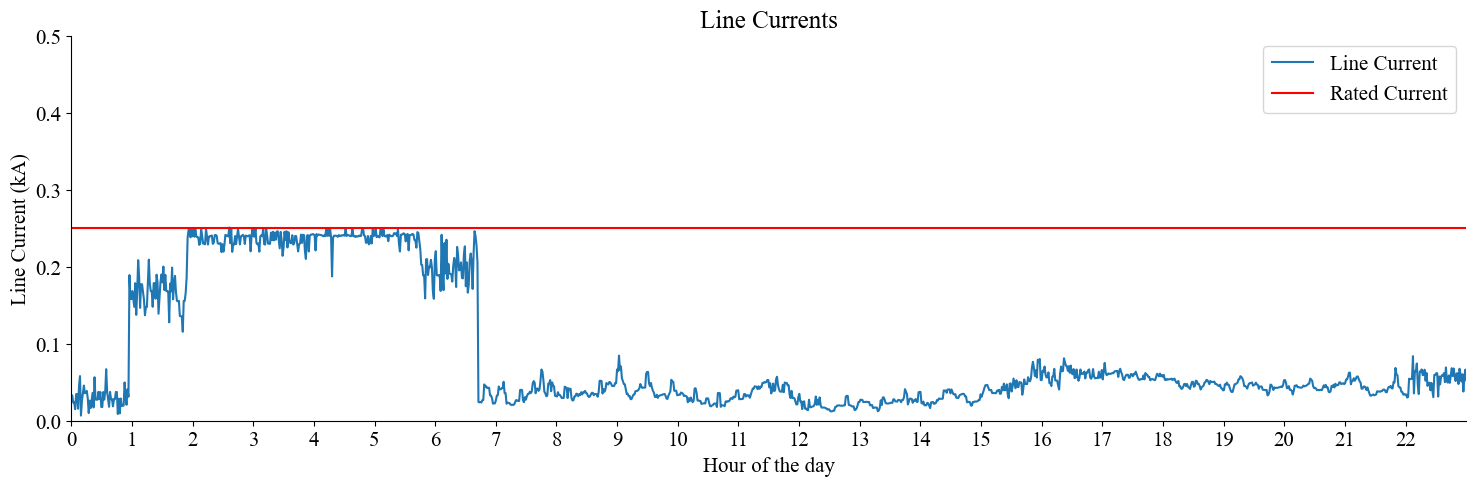

In [29]:
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)
plt.plot(np.linspace(0,23,1*1440),np.array(line_current_npv)[(days-1)*1440:])
plt.xlabel('Hour of the day')
plt.axhline(y=0.25, color='r', linestyle='-')
plt.legend(['Line Current', 'Rated Current'])
plt.ylabel('Line Current (kA)')
plt.title('Line Currents')
plt.xlim(0,23)
plt.xticks([i for i in range(0,23)]);
plt.ylim(0,0.5)
plt.grid(visible=None)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1);

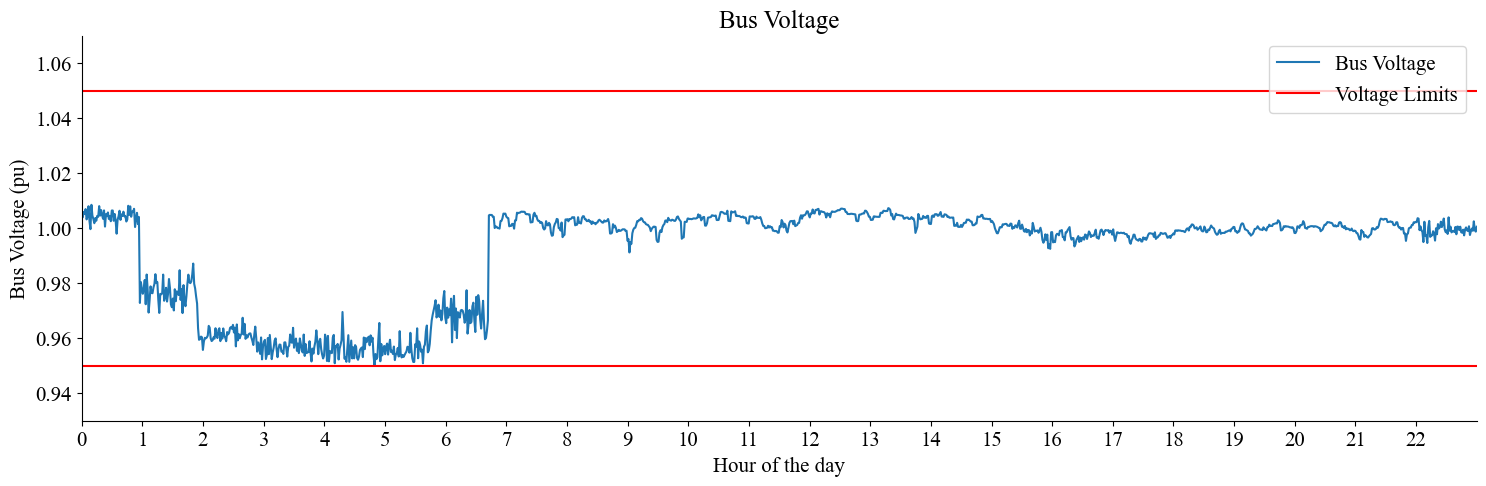

In [30]:
fig, ax = plt.subplots(figsize=(18, 5), dpi=100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family': 'Times New Roman', 'size': 15}
plt.rc('font', **font)
plt.plot(np.linspace(0,23,1*1440),np.array(voltage_npv)[(days-1)*1440:])
plt.xlabel('Hour of the day')
plt.axhline(y=1.05, color='r', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.legend(['Bus Voltage', 'Voltage Limits'])
plt.ylabel('Bus Voltage (pu)')
plt.title('Bus Voltage')
plt.xlim(0,23)
plt.xticks([i for i in range(0,23)]);
plt.ylim(0.93,1.07)
plt.grid(visible=None)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1);

## Combinatorial Bandits

In [31]:
# Declaring EV agents for each EV in the network
ev_agents_index  = np.ndarray((len(net.storage)),dtype=object)
for e in range(0,len(net.storage)):
    ev_agents_index[e] = ev_agent_py.EV_Agent(net.storage['name'][e],evs_df['t_arrive'][e],evs_df['t_depart(d+1)'][e],
                                              evs_df['chrg_req'][e],1,electricity_price,100,0* solar_data[29]/24)

In [32]:
# Declaring line agent for the studied congested electrical line
line_agent = line_agent_py.Line_Agent('Line 0', 0.27, electricity_price)

In [ ]:
ext_grid_p = []
ext_grid_q = []
line_current = []
avg_rewards = np.zeros((len(net.storage),days*daily_decision_instants))
reward_hist = np.zeros((len(net.storage),days*daily_decision_instants))
voltage = []
trfo_p = []


for t in tqdm(range(0,days*daily_decision_instants)):
    minute_of_day = t%1440
    hour = int(math.ceil((minute_of_day+1)/60))-1

    if (minute_of_day == 0):
        for a in range(0,len(ev_agents_index)):
            ev_agents_index[a].select_actions()

    for l in range(0,len(net.load)):
        net.load['p_mw'][l] = load_active_power[l][minute_of_day]/1000
        net.load['q_mvar'][l] = load_reactive_power[l][minute_of_day]/1000
        net.sgen['p_mw'][l] = solar_data[int(np.floor(t/1440))][minute_of_day]/1000

    for l in range(0,len(net.storage)):
        if(minute_of_day in ev_agents_index[l].selected_actions):
            net.storage['p_mw'][l] = (7/1000)
        elif (minute_of_day in np.where(ev_agents_index[l].solar_estimate>=0.2)[0]):
            net.storage['p_mw'][l] = (ev_agents_index[l].solar_estimate[minute_of_day]/1000)
        else:
            net.storage['p_mw'][l] = 0

    #Running Power Flow
    runpp_pp(net, time_step = 60)
    update_states(net)
    ext_grid_p.append(net.res_ext_grid['p_mw'][0])
    ext_grid_q.append(net.res_ext_grid['q_mvar'][0])
    line_current.append(net.res_line['i_ka'][0])

    for l in range(0,len(net.storage)):
        ev_agents_index[l].inst_voltage = net.res_bus['vm_pu'][net.storage['bus'][l]]


    #Bandit Algorithm
    #print(minute_of_day)
    line_agent.reward_evs(minute_of_day, net.res_line['i_ka'][0], ev_agents_index)
    voltage.append(net.res_bus['vm_pu'][205])
    trfo_p.append(net.res_trafo['p_lv_mw'][0])

    for e in range(0,len(net.storage)):
        ev_slots = np.linspace(evs_df['t_arrive'][e] , 1440+evs_df['t_depart(d+1)'][e], (1440-evs_df['t_arrive'][e]) + evs_df['t_depart(d+1)'][e]+1)%1440
        if (minute_of_day in ev_slots):
            ev_agents_index[e].update_solar_estimate(minute_of_day,min(solar_data[int(np.floor(t/1440))][minute_of_day]/evs_p[minute_of_day],7))

    #        if (minute_of_day in np.where(ev_agents_index[l].theta_solar>=0.2)[0]):
    #            ev_agents_index[e].update_solar_estimate(minute_of_day,solar_data[int(np.floor(t/1440))][minute_of_day])

    for e in range(0,len(net.storage)):
        avg_rewards[e][t] = avg_rewards[e][t-1] + (ev_agents_index[e].get_avg_reward() - avg_rewards[e][t-1])/(t+1)
        reward_hist[e][t] = (ev_agents_index[e].get_avg_reward())


  2%|▏         | 769/43200 [00:58<52:39, 13.43it/s]

In [ ]:
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)
plt.plot(np.linspace(0,23,1*1440),np.array(line_current)[(days-1)*1440:])
plt.xlabel('Hour of the day')
plt.axhline(y=0.25, color='r', linestyle='-')
plt.legend(['Line Current', 'Rated Current'])
plt.ylabel('Line Current (kA)')
plt.title('Line Currents')
plt.xlim(0,23)
plt.xticks([i for i in range(0,23)]);
plt.ylim(0,0.5)
plt.grid(visible=None)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5), dpi=100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family': 'Times New Roman', 'size': 15}
plt.rc('font', **font)
plt.plot(np.linspace(0,23,1*1440),np.array(voltage_npv)[(days-1)*1440:])
plt.xlabel('Hour of the day')
plt.axhline(y=1.05, color='r', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.legend(['Bus Voltage', 'Voltage Limits'])
plt.ylabel('Bus Voltage (pu)')
plt.title('Bus Voltage')
plt.xlim(0,23)
plt.xticks([i for i in range(0,23)]);
plt.ylim(0.93,1.07)
plt.grid(visible=None)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1);